<a href="https://colab.research.google.com/github/asadstat/Data_analysis/blob/master/CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install contractions
!pip install textsearch
!pip install tqdm
import nltk
nltk.download('punkt')

In [ ]:
import pandas as pd
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from sklearn.preprocessing import LabelEncoder

# fix random seed for reproducibility
seed = 42
np.random.seed(seed)

In [ ]:
dataset = pd.read_csv(r'/content/drive/MyDrive/data/sentiment.csv',usecols=['domain','title','content','Sentiment'])
dataset.info()

In [ ]:
# take a peek at the data
dataset.head()

,domain,title,Contu,Analysis
0,marketbeat,Three Industrial Giants You Should Own In 2No2No,With end year around corner past time think po...,Yes
1,marketbeat,Labor Stocks Are Going To Break Out In 2No2No,The labor markets one closely watched segment ...,Yes
2,marketbeat,"Tesla (TSLA) Breaks Shipment Record, Beats Est...",It could forgiven might think Tesla NASDAQ TSL...,Yes
3,ciodive,"On the road to AI adoption, execs grapple with...",CIOs kicked 2NoYes9 AI item watch competition ...,Yes
4,instyle,Red Carpet Sustainability After Coronavirus Sh...,When coronavirus pandemic life returns normal ...,Yes


In [ ]:
# build train and test datasets
reviews = dataset['Contu'].values
sentiments = dataset['Analysis'].values

train_reviews = reviews[:350]
train_sentiments = sentiments[:350]

test_reviews = reviews[350:]
test_sentiments = sentiments[350:]

In [ ]:
import contractions
from bs4 import BeautifulSoup
import numpy as np
import re
import tqdm
import unicodedata


def strip_html_tags(text):
  soup = BeautifulSoup(text, "html.parser")
  [s.extract() for s in soup(['iframe', 'script'])]
  stripped_text = soup.get_text()
  stripped_text = re.sub(r'[\r|\n|\r\n]+', '\n', stripped_text)
  return stripped_text

def remove_accented_chars(text):
  text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
  return text

def pre_process_corpus(docs):
  norm_docs = []
  for doc in tqdm.tqdm(docs):
    doc = strip_html_tags(doc)
    doc = doc.translate(doc.maketrans("\n\t\r", "   "))
    doc = doc.lower()
    doc = remove_accented_chars(doc)
    doc = contractions.fix(doc)
    # lower case and remove special characters\whitespaces
    doc = re.sub(r'[^a-zA-Z0-9\s]', '', doc, re.I|re.A)
    doc = re.sub(' +', ' ', doc)
    doc = doc.strip()  
    norm_docs.append(doc)
  
  return norm_docs

In [ ]:
%%time

norm_train_reviews = pre_process_corpus(train_reviews)
norm_test_reviews = pre_process_corpus(test_reviews)

100%|██████████| 150/150 [00:00<00:00, 757.59it/s]

CPU times: user 484 ms, sys: 4.6 ms, total: 488 ms
Wall time: 524 ms


In [ ]:
t = Tokenizer(oov_token='<UNK>')
# fit the tokenizer on the documents
t.fit_on_texts(norm_train_reviews)
t.word_index['<PAD>'] = 0

In [ ]:
max([(k, v) for k, v in t.word_index.items()], key = lambda x:x[1]), min([(k, v) for k, v in t.word_index.items()], key = lambda x:x[1]), t.word_index['<UNK>']

(('griffiths', 14575), ('<PAD>', 0), 1)

In [ ]:
train_sequences = t.texts_to_sequences(norm_train_reviews)

In [ ]:
test_sequences = t.texts_to_sequences(norm_test_reviews)

In [ ]:
print("Vocabulary size={}".format(len(t.word_index)))
print("Number of Documents={}".format(t.document_count))

Vocabulary size=14576
Number of Documents=350


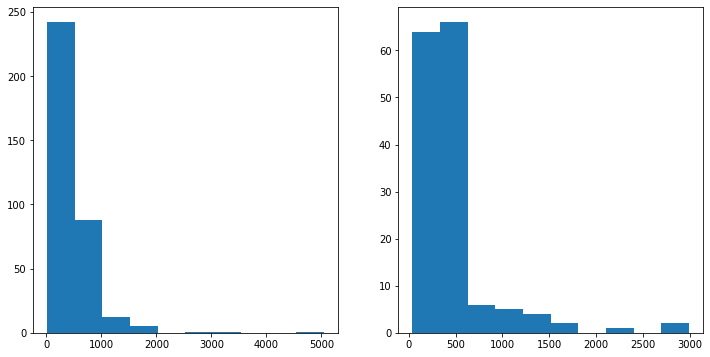

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

train_lens = [len(s) for s in train_sequences]
test_lens = [len(s) for s in test_sequences]

fig, ax = plt.subplots(1,2, figsize=(12, 6))
h1 = ax[0].hist(train_lens)
h2 = ax[1].hist(test_lens)

In [ ]:
MAX_SEQUENCE_LENGTH = 1000

In [ ]:
# pad dataset to a maximum review length in words
X_train = sequence.pad_sequences(train_sequences, maxlen=MAX_SEQUENCE_LENGTH)
X_test = sequence.pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH)
X_train.shape, X_test.shape

((350, 1000), (150, 1000))

In [ ]:
le = LabelEncoder()
num_classes=2 # positive -> 1, negative -> 0

In [ ]:
y_train = le.fit_transform(train_sentiments)
y_test = le.transform(test_sentiments)

In [ ]:
VOCAB_SIZE = len(t.word_index)

In [ ]:
EMBED_SIZE = 300
EPOCHS=2
BATCH_SIZE=128

In [ ]:
# create the model
model = Sequential()
model.add(Embedding(VOCAB_SIZE, EMBED_SIZE, input_length=MAX_SEQUENCE_LENGTH))
model.add(Conv1D(filters=128, kernel_size=4, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=64, kernel_size=4, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=32, kernel_size=4, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1000, 300)         4372800   
                                                                 
 conv1d (Conv1D)             (None, 1000, 128)         153728    
                                                                 
 max_pooling1d (MaxPooling1D  (None, 500, 128)         0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 500, 64)           32832     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 250, 64)          0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (None, 250, 32)           8

In [ ]:
# Fit the model
history_cnn =model.fit(X_train, y_train, 
          validation_split=0.1,
          epochs=EPOCHS, 
          batch_size=BATCH_SIZE, 
          verbose=1)

Epoch 1/2
3/3 [==============================] - 14s 4s/step - loss: 0.5277 - accuracy: 0.6540 - val_loss: 0.0082 - val_accuracy: 1.0000
Epoch 2/2
3/3 [==============================] - 14s 4s/step - loss: 0.3872 - accuracy: 0.9175 - val_loss: 0.0921 - val_accuracy: 1.0000


In [ ]:
from keras.backend import clear_session
clear_session()

In [ ]:
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 0.9257
Testing Accuracy:  0.8933


In [ ]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history_cnn):
    acc = history_cnn.history['accuracy']
    val_acc = history_cnn.history['val_accuracy']
    loss = history_cnn.history['loss']
    val_loss = history_cnn.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

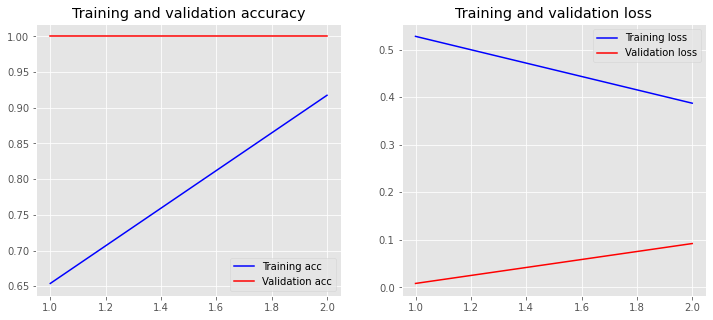

In [ ]:
plot_history(history_cnn)

In [ ]:
pred_cnn = (model.predict(X_test) > 0.5).astype("int32")
from sklearn.metrics import accuracy_score
print(accuracy_score(y_test,pred_cnn))

In [ ]:
import sklearn.metrics as metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
# Calculate the accuracy score
accuracy_cnn = metrics.accuracy_score(y_test,pred_cnn)
print(accuracy_cnn)
Conf_metrics_cnn = metrics.confusion_matrix(y_test,pred_cnn, labels=['1', '0'])

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
labels = ['1', '0']
print(classification_report(y_test, pred_cnn))
pd.DataFrame(confusion_matrix(y_test, pred_cnn), index=labels, columns=labels)

In [ ]:
conf_cnn = metrics.confusion_matrix(y_test,pred_cnn)
conf_cnn

In [ ]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
import itertools

np.random.seed(42)  # for reproducibility
sns.set(rc={"figure.figsize": (8, 8)})
sns.set_style("ticks")

In [ ]:
classes = [0, 1]
# plot confusion matrix
plt.imshow(conf_cnn, interpolation='nearest', cmap=plt.cm.Greens)
plt.title("Confusion Matrix")
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)

fmt = 'd'
thresh = conf_cnn.max() / 2.
for i, j in itertools.product(range(conf_cnn.shape[0]), range(conf_cnn.shape[1])):
    plt.text(j, i, format(conf_cnn[i, j], fmt),
             horizontalalignment="center",
             color="white" if conf_cnn[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')

In [ ]:
probs = model.predict(X_test)
preds = probs

In [ ]:
import sklearn.metrics as metrics
# calculate the fpr and tpr for all thresholds of the classification
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)
# method I: plt
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()